In [1]:
!pip install scikit-learn
!pip install torchvision

In [7]:
import torch
import torchvision
import warnings

In [17]:
train_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)

test_set=torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=False, download=True,
                             transform=transformer)

batch_size_train= (int)(len(train_set)/10)
batch_size_test=len(test_set)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./files/fashion-mnist/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./files/fashion-mnist/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./files/fashion-mnist/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./files/fashion-mnist/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./files/fashion-mnist/FashionMNIST\raw



In [18]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  test_set,
  batch_size=batch_size_test, shuffle=True)

train = enumerate(train_loader)
_, (train_data, train_targets) = next(train)

test = enumerate(test_loader)
_, (test_data, test_targets) = next(test)


In [19]:
from sklearn.neighbors import KNeighborsClassifier

ks = [i+1 for i in range(15)]
procents = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    successes = 0
    attempts = 0

    knn.fit(torch.flatten(train_data, start_dim=1, end_dim=3), train_targets)
    
    with warnings.catch_warnings(record=True):
        results = knn.predict(torch.flatten(test_data, start_dim=1, end_dim=3))

    for i in range(len(results)):
        if results[i] == test_targets[i]:
            successes += 1
        attempts += 1

    procents.append(100*successes/attempts)

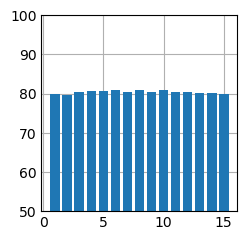

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.bar(ks, procents)

ax.set(ylim=(50, 100))

plt.show()